# XGB vs LGBM structural diff

LightGBM uses a novel technique of Gradient-based One-Side Sampling (GOSS) to filter out the data instances for finding a split value while XGBoost uses pre-sorted algorithm & Histogram-based algorithm for computing the best split. Here instances mean observations/samples.

how pre-sorting splitting works-
1. For each node, enumerate over all features
2. For each feature, sort the instances by feature value
3. Use a linear scan to decide the best split along that feature basis information gain
4. Take the best split solution along all the features

In simple terms, Histogram-based algorithm splits all the data points for a feature into discrete bins and uses these bins to find the split value of histogram. While, it is efficient than pre-sorted algorithm in training speed which enumerates all possible split points on the pre-sorted feature values, it is still behind GOSS in terms of speed.

So what makes this GOSS method efficient?
In AdaBoost, the sample weight serves as a good indicator for the importance of samples. However, in Gradient 
Gradient represents the slope of the tangent of the loss function, so logically if gradient of data points are large in some sense, these points are important for finding the optimal split point as they have higher error.
GOSS keeps all the instances with large gradients and performs random sampling on the instances with small gradients. For example, let’s say I have 500K rows of data where 10k rows have higher gradients. So my algorithm will choose (10k rows of higher gradient+ x% of remaining 490k rows chosen randomly). Assuming x is 10%, total rows selected are 59k out of 500K on the basis of which split value if found.

In order to keep the same data distribution, when computing the information gain, GOSS introduces a constant multiplier for the data instances with small gradients. Thus, GOSS achieves a good balance between reducing the number of data instances and keeping the accuracy for learned decision trees.


## How each model treats Categorical Variables?

### CatBoost
CatBoost has the flexibility of giving indices of categorical columns so that it can be encoded as one-hot encoding using one_hot_max_size (Use one-hot encoding for all features with number of different values less than or equal to the given parameter value).
If you don’t pass any anything in cat_features argument, CatBoost will treat all the columns as numerical variables.

### LGBM
LightGBM can also handle categorical features by taking the input of feature names. It does not convert to one-hot coding, and is much faster than one-hot coding.we should convert your categorical features to int type before you construct Dataset for LGBM. It does not accept string values even if you passes it through categorical_feature parameter.

### XGB

Unlike CatBoost or LGBM, XGBoost cannot handle categorical features by itself, it only accepts numerical values similar to Random Forest. Therefore one has to perform various encodings like label encoding, mean encoding or one-hot encoding before supplying categorical data to XGBoost.


## Parameters Similarity
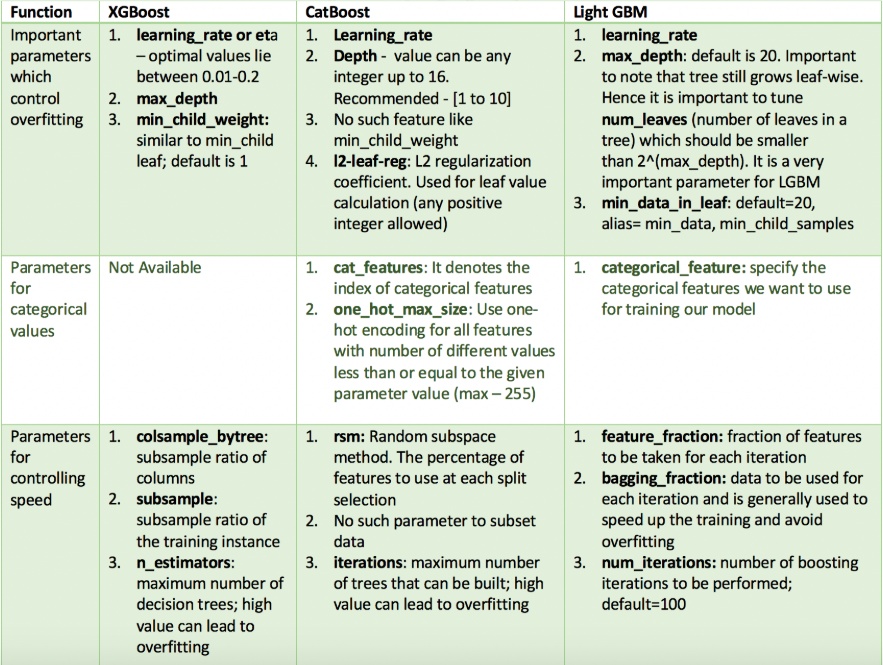


In [26]:
import pandas as pd, numpy as np, time
from sklearn.model_selection import train_test_split


In [27]:
#Reading the file
data = pd.read_csv("flights.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
#Taking random sample for modelling
data = data.sample(frac = 0.1, random_state=10)

In [29]:
data.shape

(581908, 31)

In [30]:
data.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
411984,2015,1,28,3,WN,103,N7728D,DCA,MKE,705,...,811.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3591965,2015,8,11,2,B6,153,N592JB,JFK,PBI,1859,...,345.0,337.0,0,0,NaN,0.0,0.0,82.0,255.0,0.0
526451,2015,2,4,3,DL,1187,N921DN,MSP,DCA,1735,...,2043.0,-19.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1336011,2015,3,27,5,WN,171,N407WN,DEN,RDU,1815,...,2313.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3424502,2015,8,1,6,WN,4330,N7751A,ATL,RIC,2125,...,2318.0,13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
#Selecting usefull features
data = data[["MONTH","DAY","DAY_OF_WEEK","AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT","AIR_TIME", "DEPARTURE_TIME","DISTANCE","ARRIVAL_DELAY"]]
data.dropna(inplace=True)

In [32]:
data= data.reset_index()

In [33]:
data.head()

,index,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE,ARRIVAL_DELAY
0,411984,1,28,3,WN,103,MKE,DCA,102.0,713.0,634,1.0
1,3591965,8,11,2,B6,153,PBI,JFK,134.0,111.0,1028,337.0
2,526451,2,4,3,DL,1187,DCA,MSP,111.0,1734.0,931,-19.0
3,1336011,3,27,5,WN,171,RDU,DEN,173.0,1807.0,1436,-7.0
4,3424502,8,1,6,WN,4330,RIC,ATL,63.0,2151.0,481,13.0


In [34]:
data.drop('index', axis=1,inplace=True)

In [35]:
data.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE,ARRIVAL_DELAY
0,1,28,3,WN,103,MKE,DCA,102.0,713.0,634,1.0
1,8,11,2,B6,153,PBI,JFK,134.0,111.0,1028,337.0
2,2,4,3,DL,1187,DCA,MSP,111.0,1734.0,931,-19.0
3,3,27,5,WN,171,RDU,DEN,173.0,1807.0,1436,-7.0
4,8,1,6,WN,4330,RIC,ATL,63.0,2151.0,481,13.0


In [36]:
data.to_csv('Flight_sample.csv', index=False)

In [37]:
data= pd.read_csv('Flight_sample.csv')
data.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE,ARRIVAL_DELAY
0,1,28,3,WN,103,MKE,DCA,102.0,713.0,634,1.0
1,8,11,2,B6,153,PBI,JFK,134.0,111.0,1028,337.0
2,2,4,3,DL,1187,DCA,MSP,111.0,1734.0,931,-19.0
3,3,27,5,WN,171,RDU,DEN,173.0,1807.0,1436,-7.0
4,8,1,6,WN,4330,RIC,ATL,63.0,2151.0,481,13.0


In [12]:
#labelling dependent variable as 1 if delay is greater than 10 else 0
data["ARRIVAL_DELAY"] = (data["ARRIVAL_DELAY"]>10)*1

In [13]:
data.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,DESTINATION_AIRPORT,ORIGIN_AIRPORT,AIR_TIME,DEPARTURE_TIME,DISTANCE,ARRIVAL_DELAY
0,1,28,3,WN,103,MKE,DCA,102.0,713.0,634,0
1,8,11,2,B6,153,PBI,JFK,134.0,111.0,1028,1
2,2,4,3,DL,1187,DCA,MSP,111.0,1734.0,931,0
3,3,27,5,WN,171,RDU,DEN,173.0,1807.0,1436,0
4,8,1,6,WN,4330,RIC,ATL,63.0,2151.0,481,1


In [15]:
#Coding the cat variables
cols = ["AIRLINE","FLIGHT_NUMBER","DESTINATION_AIRPORT","ORIGIN_AIRPORT"]
for item in cols:
    data[item] = data[item].astype("category").cat.codes +1

In [16]:
train, test, y_train, y_test = train_test_split(data.drop(["ARRIVAL_DELAY"], axis=1), data["ARRIVAL_DELAY"],
                                                random_state=10, test_size=0.25)

## XGB

In [17]:
import xgboost as xgb
from sklearn import metrics

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

# # Parameter Tuning
# model = xgb.XGBClassifier()
# param_dist = {"max_depth": [10,30,50],
#               "min_child_weight" : [1,3,6],
#               "n_estimators": [200],
#               "learning_rate": [0.05, 0.1,0.16],}
# grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
#                                    verbose=10, n_jobs=-1)
# grid_search.fit(train, y_train)

# grid_search.best_estimator_



In [18]:
model = xgb.XGBClassifier(max_depth=50, min_child_weight=1,  n_estimators=200,
                          n_jobs=-1 , verbose=1,learning_rate=0.16)
model.fit(train,y_train)

auc(model, train, test)

(1.0, 0.7889990423308817)

## LGBM

In [19]:
import lightgbm as lgb


def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict(train)),
                            metrics.roc_auc_score(y_test,m.predict(test)))

# lg = lgb.LGBMClassifier(silent=False)
# param_dist = {"max_depth": [25,50, 75],
#               "learning_rate" : [0.01,0.05,0.1],
#               "num_leaves": [300,900,1200],
#               "n_estimators": [200]
#              }
# grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
# grid_search.fit(train,y_train)
# grid_search.best_estimator_


/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [24]:

d_train = lgb.Dataset(train, label=y_train)
params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}

# Without Categorical Features
model2 = lgb.train(params, d_train)
print('without:', auc2(model2, train, test))

d_train = lgb.Dataset(train, label=y_train, free_raw_data=False)
#With Catgeorical Features
cate_features_name = ["MONTH","DAY","DAY_OF_WEEK","AIRLINE","DESTINATION_AIRPORT",
                 "ORIGIN_AIRPORT"]
model2 = lgb.train(params, d_train, categorical_feature = cate_features_name)
print('with cat:',auc2(model2, train, test))

/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


without: (0.9813891619762243, 0.7850159220067868)


/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AIRLINE', 'DAY', 'DAY_OF_WEEK', 'DESTINATION_AIRPORT', 'MONTH', 'ORIGIN_AIRPORT']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


with cat: (0.9984732007973849, 0.7743203202369899)


## Catboost

In [22]:
import catboost as cb
cat_features_index = [0,1,2,3,4,5,6]

def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                            metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

# params = {'depth': [4, 7, 10],
#           'learning_rate' : [0.03, 0.1, 0.15],
#          'l2_leaf_reg': [1,4,9],
#          'iterations': [300]}
# cb = cb.CatBoostClassifier()
# cb_model = GridSearchCV(cb, params, scoring="roc_auc", cv = 3)
# cb_model.fit(train, y_train)



In [25]:
# Without Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC", depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(train,y_train)
print('without:',auc(clf, train, test))

# With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=31, \
                            depth=10, iterations= 500, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(train,y_train, cat_features= cat_features_index)
print('with:',auc(clf, train, test))

0:	total: 205ms	remaining: 1m 42s
1:	total: 459ms	remaining: 1m 54s
2:	total: 981ms	remaining: 2m 42s
3:	total: 1.15s	remaining: 2m 23s
4:	total: 1.42s	remaining: 2m 20s
5:	total: 1.68s	remaining: 2m 17s
6:	total: 1.94s	remaining: 2m 16s
7:	total: 2.2s	remaining: 2m 15s
8:	total: 2.45s	remaining: 2m 13s
9:	total: 2.71s	remaining: 2m 13s
10:	total: 2.96s	remaining: 2m 11s
11:	total: 3.21s	remaining: 2m 10s
12:	total: 3.45s	remaining: 2m 9s
13:	total: 3.69s	remaining: 2m 8s
14:	total: 3.94s	remaining: 2m 7s
15:	total: 4.2s	remaining: 2m 7s
16:	total: 4.44s	remaining: 2m 6s
17:	total: 4.68s	remaining: 2m 5s
18:	total: 4.92s	remaining: 2m 4s
19:	total: 5.17s	remaining: 2m 4s
20:	total: 5.42s	remaining: 2m 3s
21:	total: 5.66s	remaining: 2m 3s
22:	total: 5.91s	remaining: 2m 2s
23:	total: 6.16s	remaining: 2m 2s
24:	total: 6.41s	remaining: 2m 1s
25:	total: 6.66s	remaining: 2m 1s
26:	total: 6.9s	remaining: 2m
27:	total: 7.14s	remaining: 2m
28:	total: 7.39s	remaining: 2m
29:	total: 7.66s	remaini

233:	total: 59.4s	remaining: 1m 7s
234:	total: 59.6s	remaining: 1m 7s
235:	total: 59.9s	remaining: 1m 6s
236:	total: 1m	remaining: 1m 6s
237:	total: 1m	remaining: 1m 6s
238:	total: 1m	remaining: 1m 6s
239:	total: 1m	remaining: 1m 5s
240:	total: 1m 1s	remaining: 1m 5s
241:	total: 1m 1s	remaining: 1m 5s
242:	total: 1m 1s	remaining: 1m 5s
243:	total: 1m 1s	remaining: 1m 4s
244:	total: 1m 2s	remaining: 1m 4s
245:	total: 1m 2s	remaining: 1m 4s
246:	total: 1m 2s	remaining: 1m 4s
247:	total: 1m 2s	remaining: 1m 3s
248:	total: 1m 3s	remaining: 1m 3s
249:	total: 1m 3s	remaining: 1m 3s
250:	total: 1m 3s	remaining: 1m 3s
251:	total: 1m 3s	remaining: 1m 2s
252:	total: 1m 4s	remaining: 1m 2s
253:	total: 1m 4s	remaining: 1m 2s
254:	total: 1m 4s	remaining: 1m 2s
255:	total: 1m 4s	remaining: 1m 1s
256:	total: 1m 5s	remaining: 1m 1s
257:	total: 1m 5s	remaining: 1m 1s
258:	total: 1m 5s	remaining: 1m 1s
259:	total: 1m 5s	remaining: 1m
260:	total: 1m 6s	remaining: 1m
261:	total: 1m 6s	remaining: 1m
262:	t

464:	total: 1m 58s	remaining: 8.89s
465:	total: 1m 58s	remaining: 8.63s
466:	total: 1m 58s	remaining: 8.38s
467:	total: 1m 58s	remaining: 8.13s
468:	total: 1m 59s	remaining: 7.87s
469:	total: 1m 59s	remaining: 7.62s
470:	total: 1m 59s	remaining: 7.36s
471:	total: 1m 59s	remaining: 7.11s
472:	total: 2m	remaining: 6.86s
473:	total: 2m	remaining: 6.6s
474:	total: 2m	remaining: 6.35s
475:	total: 2m	remaining: 6.09s
476:	total: 2m 1s	remaining: 5.84s
477:	total: 2m 1s	remaining: 5.58s
478:	total: 2m 1s	remaining: 5.33s
479:	total: 2m 1s	remaining: 5.08s
480:	total: 2m 2s	remaining: 4.82s
481:	total: 2m 2s	remaining: 4.57s
482:	total: 2m 2s	remaining: 4.32s
483:	total: 2m 2s	remaining: 4.06s
484:	total: 2m 3s	remaining: 3.81s
485:	total: 2m 3s	remaining: 3.55s
486:	total: 2m 3s	remaining: 3.3s
487:	total: 2m 3s	remaining: 3.04s
488:	total: 2m 4s	remaining: 2.79s
489:	total: 2m 4s	remaining: 2.54s
490:	total: 2m 4s	remaining: 2.28s
491:	total: 2m 4s	remaining: 2.03s
492:	total: 2m 5s	remainin

194:	total: 2m 23s	remaining: 3m 44s
195:	total: 2m 24s	remaining: 3m 44s
196:	total: 2m 25s	remaining: 3m 43s
197:	total: 2m 25s	remaining: 3m 42s
198:	total: 2m 26s	remaining: 3m 41s
199:	total: 2m 27s	remaining: 3m 40s
200:	total: 2m 27s	remaining: 3m 40s
201:	total: 2m 28s	remaining: 3m 39s
202:	total: 2m 29s	remaining: 3m 38s
203:	total: 2m 30s	remaining: 3m 38s
204:	total: 2m 31s	remaining: 3m 37s
205:	total: 2m 31s	remaining: 3m 36s
206:	total: 2m 32s	remaining: 3m 35s
207:	total: 2m 33s	remaining: 3m 35s
208:	total: 2m 33s	remaining: 3m 34s
209:	total: 2m 34s	remaining: 3m 33s
210:	total: 2m 35s	remaining: 3m 32s
211:	total: 2m 36s	remaining: 3m 31s
212:	total: 2m 36s	remaining: 3m 31s
213:	total: 2m 37s	remaining: 3m 30s
214:	total: 2m 38s	remaining: 3m 29s
215:	total: 2m 38s	remaining: 3m 28s
216:	total: 2m 39s	remaining: 3m 28s
217:	total: 2m 40s	remaining: 3m 27s
218:	total: 2m 41s	remaining: 3m 26s
219:	total: 2m 41s	remaining: 3m 26s
220:	total: 2m 42s	remaining: 3m 25s
2

419:	total: 5m 9s	remaining: 58.9s
420:	total: 5m 9s	remaining: 58.2s
421:	total: 5m 10s	remaining: 57.4s
422:	total: 5m 11s	remaining: 56.7s
423:	total: 5m 12s	remaining: 55.9s
424:	total: 5m 12s	remaining: 55.2s
425:	total: 5m 13s	remaining: 54.4s
426:	total: 5m 13s	remaining: 53.7s
427:	total: 5m 14s	remaining: 53s
428:	total: 5m 15s	remaining: 52.2s
429:	total: 5m 15s	remaining: 51.4s
430:	total: 5m 16s	remaining: 50.7s
431:	total: 5m 17s	remaining: 49.9s
432:	total: 5m 17s	remaining: 49.2s
433:	total: 5m 18s	remaining: 48.4s
434:	total: 5m 19s	remaining: 47.7s
435:	total: 5m 19s	remaining: 47s
436:	total: 5m 20s	remaining: 46.2s
437:	total: 5m 21s	remaining: 45.5s
438:	total: 5m 22s	remaining: 44.8s
439:	total: 5m 22s	remaining: 44s
440:	total: 5m 23s	remaining: 43.3s
441:	total: 5m 24s	remaining: 42.6s
442:	total: 5m 25s	remaining: 41.8s
443:	total: 5m 26s	remaining: 41.1s
444:	total: 5m 26s	remaining: 40.4s
445:	total: 5m 27s	remaining: 39.7s
446:	total: 5m 28s	remaining: 38.9s


## Evaluation
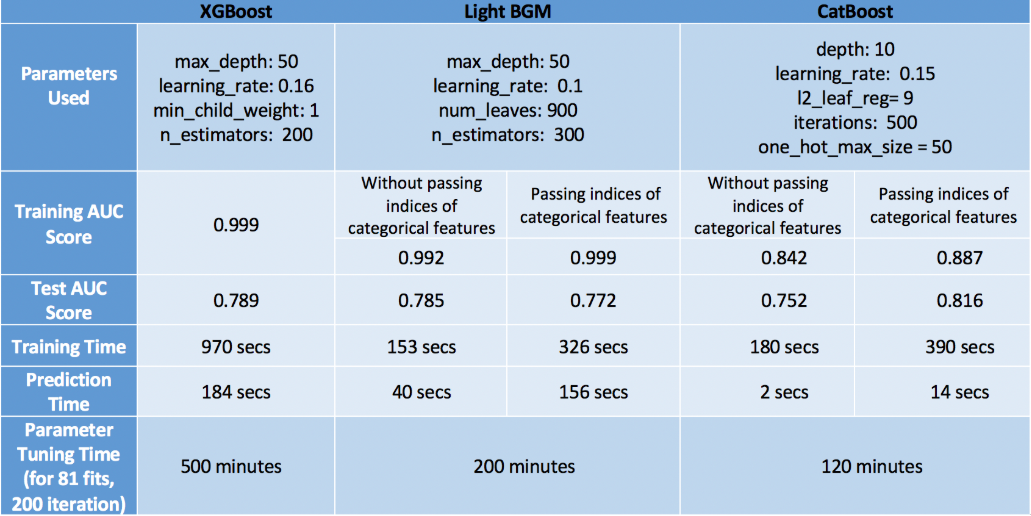

CatBoost comes out as the winner with maximum accuracy on test set (0.816), minimum overfitting (both train and test accuracy are close) and minimum prediction time & tuning time. But this happened only because we considered categorical variables and tuned one_hot_max_size. If we don’t take advantage of these features of CatBoost, it turned out to be the worst performer with just 0.752 accuracy. Hence we learnt that CatBoost performs well only when we have categorical variables in the data and we properly tune them.

Our next performer was XGBoost which generally works well. It’s accuracy was quite close to CatBoost even after ignoring the fact that we have categorical variables in the data which we had converted into numerical values for its consumption. However, the only problem with XGBoost is that it is too slow. It was really frustrating to tune its parameters especially (took me 6 hours to run GridSearchCV — very bad idea!). The better way is to tune parameters separately rather than using GridSearchCV. 

Finally, the last place goes to Light GBM. An important thing to note here is that it performed poorly in terms of both speed and accuracy when cat_features is used. I believe the reason why it performed badly was because it uses some kind of modified mean encoding for categorical data which caused overfitting (train accuracy is quite high — 0.999 compared to test accuracy). However if we use it normally like XGBoost, it can achieve similar (if not higher) accuracy with much faster speed compared to XGBoost
(LGBM — 0.785, XGBoost — 0.789).

Lastly, I have to say that these observations are true for this particular dataset and may or may not remain valid for other datasets. However, one thing which is true in general is that XGBoost is slower than the other two algorithms.